# KTR Pyro Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from orbit.models.ktr import KTRFull, KTRAggregated, KTRMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
DATA_FILE = "./data/iclaims_example.csv"
date_col = 'week'
response_col = 'claims'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

### Train / Test Split

In [6]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## VI Fit and Predict - Fully Bayesian

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [26]:
ktr_vi = KTRFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=2,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale = 10,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[.1] * 3,
    regressor_knot_scale=[1] * 3,
 
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=True,
    message=100,
    n_bootstrap_draws=200,
    estimator_type=PyroEstimatorVI,
)

In [27]:
%%time
ktr_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 1.7245e+05, scale = 0.11088
step  100 loss = 16442, scale = 0.82809
step  200 loss = -84.214, scale = 0.47499
step  300 loss = -129.74, scale = 0.62405
step  400 loss = -131.48, scale = 0.64468
step  500 loss = -129.6, scale = 0.63903
step  600 loss = -131.12, scale = 0.63652
step  700 loss = -131.26, scale = 0.62047
step  800 loss = -132.35, scale = 0.6433
step  900 loss = -133.24, scale = 0.64709
CPU times: user 3min 4s, sys: 4.37 s, total: 3min 8s
Wall time: 17.8 s


In [28]:
predicted_df = ktr_vi.predict(df=test_df, random_state=123)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.20554,12.45080,12.70213
1,2017-07-09,12.17136,12.43615,12.65249
2,2017-07-16,12.12208,12.33018,12.57575
3,2017-07-23,12.08865,12.30567,12.56960
4,2017-07-30,12.12280,12.34900,12.52672


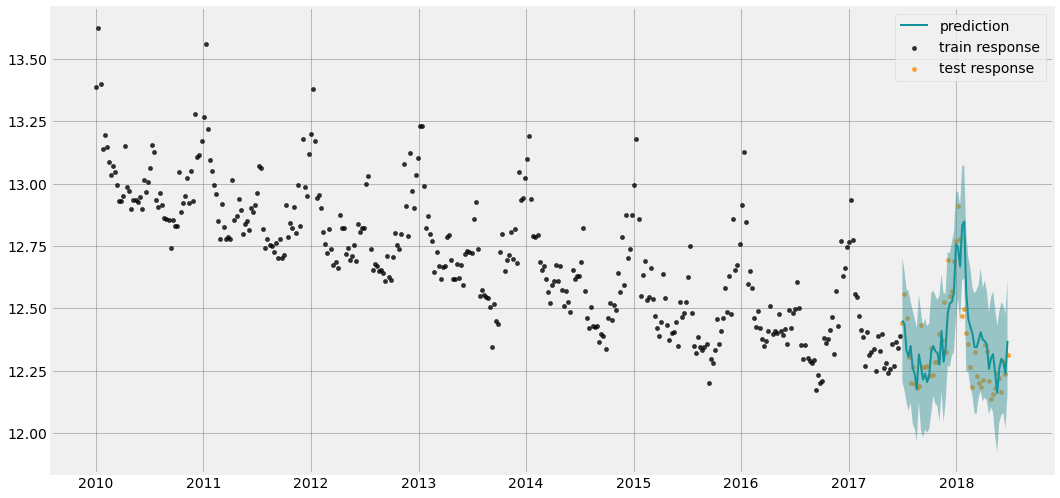

In [29]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [21]:
coef_df = ktr_vi.get_regression_coefs(aggregate_method='mean')
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.34533,1.06534,0.12161
1,2010-01-10,0.35068,1.06224,0.12147
2,2010-01-17,0.35610,1.05908,0.12133
3,2010-01-24,0.36161,1.05588,0.12118
4,2010-01-31,0.36720,1.05262,0.12104


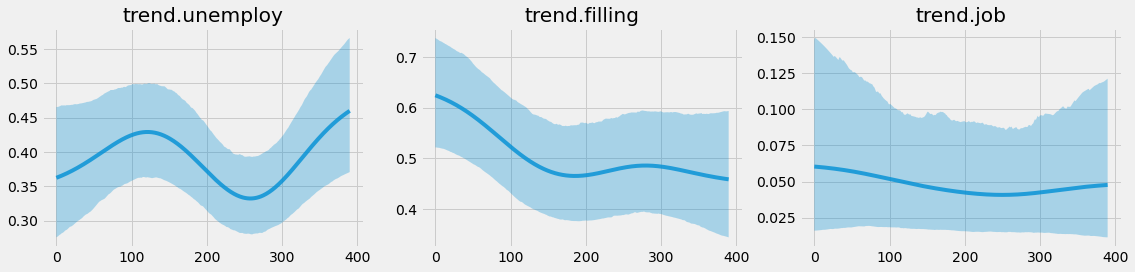

In [16]:
_ = ktr_vi.plot_regression_coefs(ncol=3, figsize=(16, 4), include_ci=True)

## VI Fit and Predict - Aggregated

In [18]:
ktr_vi_agg = KTRAggregated(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=2,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale = 10,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[.1] * 3,
    regressor_knot_scale=[1] * 3,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=False,
    message=100,
    aggregate_method='median',
    estimator_type=PyroEstimatorVI,
)

In [19]:
%%time
ktr_vi_agg.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


CPU times: user 3min 4s, sys: 3.15 s, total: 3min 7s
Wall time: 17.3 s


In [20]:
predicted_df = ktr_vi_agg.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52,regression
0,2017-07-02,12.43627,12.17022,0.03457,0.23147
1,2017-07-09,12.42480,12.17001,0.00824,0.24655
2,2017-07-16,12.34259,12.16981,-0.00967,0.18245
3,2017-07-23,12.31712,12.16963,-0.00258,0.15007
4,2017-07-30,12.33596,12.16947,-0.01219,0.17867


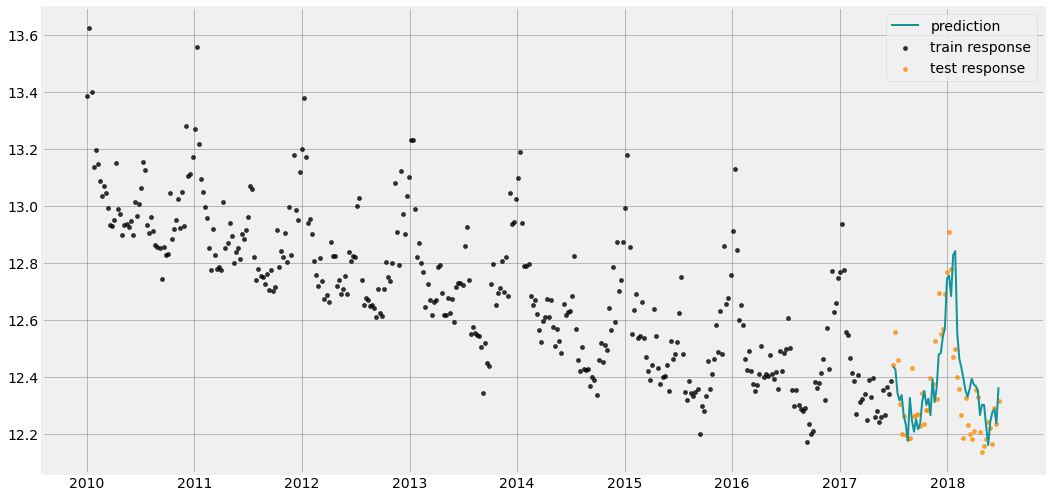

In [21]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [26]:
coef_df = ktr_vi_agg.get_regression_coefs()
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.31985,1.07427,0.09461
1,2010-01-10,0.32501,1.07104,0.09448
2,2010-01-17,0.33026,1.06775,0.09435
3,2010-01-24,0.33558,1.06442,0.09421
4,2010-01-31,0.34098,1.06102,0.09408


In [27]:
# extract future coefficients
coef_df2 = ktr_vi_agg.get_regression_coefs(date_array=test_df['week'])
coef_df2.head()

,week,trend.unemploy,trend.filling,trend.job
0,2017-07-02,1.17220,0.39123,0.04131
1,2017-07-09,1.17601,0.38868,0.04133
2,2017-07-16,1.17976,0.38617,0.04135
3,2017-07-23,1.18344,0.38371,0.04137
4,2017-07-30,1.18705,0.38128,0.04139


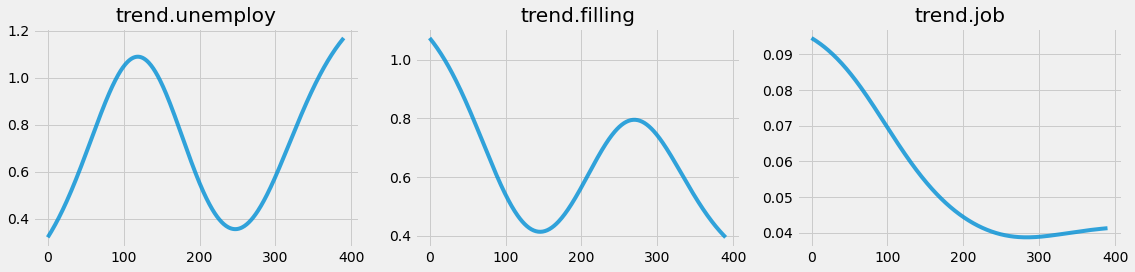

In [28]:
_ = ktr_vi_agg.plot_regression_coefs(ncol=3, figsize=(16, 4))

## VI Fit and Predict - MAP

In [29]:
ktr_map = KTRMAP(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=2,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] *3,
    
    level_knot_scale = 10,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[.1] * 3,
    regressor_knot_scale=[1] * 3,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    learning_rate=0.1,
    verbose=False,
    message=100,
    estimator_type=PyroEstimatorMAP,
)

In [30]:
%%time
ktr_map.fit(df=train_df)

CPU times: user 23.5 s, sys: 112 ms, total: 23.6 s
Wall time: 3.97 s


In [31]:
predicted_df = ktr_map.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52,regression
0,2017-07-02,12.37278,12.12958,0.00799,0.23522
1,2017-07-09,12.39173,12.12935,0.01109,0.25129
2,2017-07-16,12.31999,12.12915,0.00675,0.18409
3,2017-07-23,12.27966,12.12896,-0.00120,0.15189
4,2017-07-30,12.29920,12.12879,-0.00864,0.17905


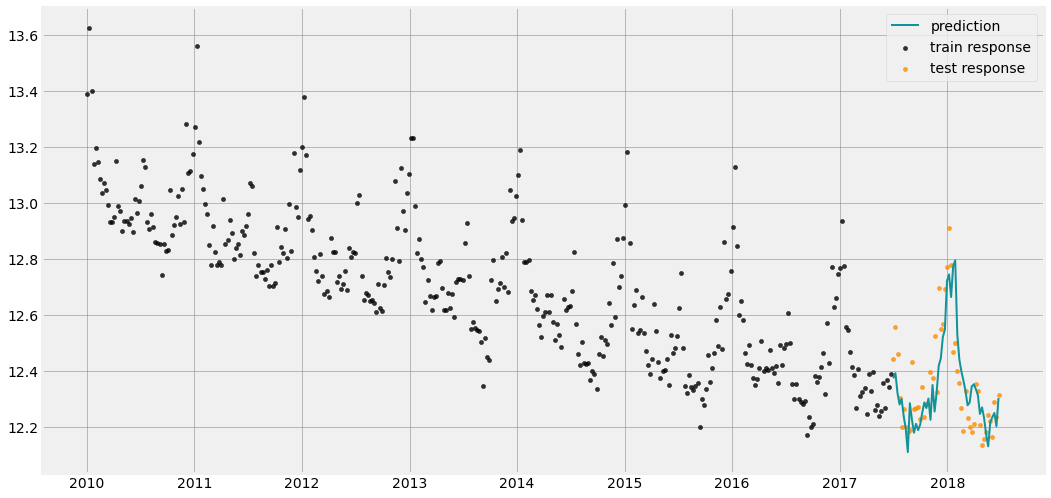

In [32]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [33]:
coef_df = ktr_map.get_regression_coefs()
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.28993,0.24448,0.00000
1,2010-01-10,0.29556,0.24537,0.00000
2,2010-01-17,0.30128,0.24628,0.00000
3,2010-01-24,0.30709,0.24719,0.00000
4,2010-01-31,0.31299,0.24812,0.00000


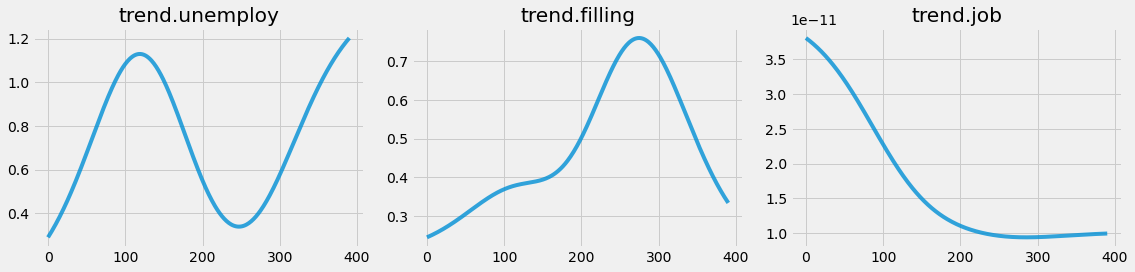

In [34]:
_ = ktr_map.plot_regression_coefs(ncol=3, figsize=(16, 4))

## hyper-parameter tuning

In [37]:
from orbit.diagnostics.backtest import grid_search_orbit
from orbit.diagnostics.metrics import smape, mape, wmape

In [38]:
# param_grid = {'num_steps': [100, 1000]}

param_grid = {'span_level': [0.1, 0.2], 'span_coefficients': [0.2, 0.3],
              'rho_level': [0.05, 0.1], 'rho_coefficients': [0.15, 0.2]}

In [40]:
best_params, tuned_df = grid_search_orbit(param_grid, 
                                        model=ktr_map, 
                                        df=df,
                                        min_train_len=100, incremental_len=100, forecast_len=20, 
                                        metrics=None, criteria=None, verbose=True)

  0%|          | 0/16 [00:00<?, ?it/s]

tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.1}


  6%|▋         | 1/16 [00:15<03:48, 15.21s/it]

tuning metric:0.065393
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.2}


 12%|█▎        | 2/16 [00:30<03:33, 15.26s/it]

tuning metric:0.012355
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.1}


 19%|█▉        | 3/16 [00:45<03:18, 15.30s/it]

tuning metric:0.090586
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.2}


 25%|██▌       | 4/16 [01:00<03:00, 15.05s/it]

tuning metric:0.081442
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.1}


 31%|███▏      | 5/16 [01:14<02:43, 14.89s/it]

tuning metric:0.068079
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.2}


 38%|███▊      | 6/16 [01:29<02:28, 14.84s/it]

tuning metric:0.15421
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.1}


 44%|████▍     | 7/16 [01:44<02:13, 14.85s/it]

tuning metric:0.012057
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.2}


 50%|█████     | 8/16 [01:59<01:58, 14.75s/it]

tuning metric:0.16231
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.1}


 56%|█████▋    | 9/16 [02:13<01:42, 14.70s/it]

tuning metric:0.068675
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.2}


 62%|██████▎   | 10/16 [02:28<01:28, 14.68s/it]

tuning metric:0.15767
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.1}


 69%|██████▉   | 11/16 [02:42<01:13, 14.62s/it]

tuning metric:0.072529
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.2}


 75%|███████▌  | 12/16 [02:57<00:58, 14.59s/it]

tuning metric:0.085704
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.1}


 81%|████████▏ | 13/16 [03:11<00:43, 14.56s/it]

tuning metric:0.086096
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.2}


 88%|████████▊ | 14/16 [03:26<00:29, 14.62s/it]

tuning metric:0.13729
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.1}


 94%|█████████▍| 15/16 [03:41<00:14, 14.62s/it]

tuning metric:0.08159
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.2}


100%|██████████| 16/16 [03:55<00:00, 14.74s/it]

tuning metric:0.1716


In [43]:
tuned_df.head()

,rho_coefficients,rho_level,span_coefficients,span_level,metrics
0,0.15000,0.05000,0.20000,0.10000,0.06539
1,0.15000,0.05000,0.20000,0.20000,0.01235
2,0.15000,0.05000,0.30000,0.10000,0.09059
3,0.15000,0.05000,0.30000,0.20000,0.08144
4,0.15000,0.10000,0.20000,0.10000,0.06808


In [42]:
best_params

[{'rho_coefficients': 0.15,
  'rho_level': 0.1,
  'span_coefficients': 0.3,
  'span_level': 0.1}]